Steps from Geir Kjetil's email:

Here are the main points - we can discuss in more detail today:
1) Due to intra-correlation, p-values at proximal sites are correlated (show as scatter plot of each p-value versus the next, or something like that
2) Due to 1, if one checks whether a p-value is below any value alpha, then this will be correlated for proximal sites (show by a 2x2 table of the chance of p-value being below alpha given that the previous p-value is so or not)
3) Still, since there are so many sites in a given [DNA-methylation-like] dataset, these intra correlations are watered out, meaning that if one picks two p-values from the same dataset, they will be almost non-correlated (scatter plot) and the chance of being below alpha is not dependent on whether any other p-value from the same dataset is so (2x2 table being neutral)
4) Since the chance of p-values being below a given alpha (success) is now essentially independent within a dataset (point 3), then the number of such successes in a dataset is close to what one would get with independent coin throws - i.e. a binomial distribution (show the empirical distribution for the number of p-values in a given dataset being below two chosen values of alpha, and plot the binomial distributions around the means of these two empirical distributions to show it is very close.
5) we now note that e.g. Bonferroni would give a binomially distributed number of significant findings. 
6) For our argument, we also note that such a binomial distribution is very typical, and that it is very natural to have an intuition around this being the case
7) However, for FDR, the value of k (as in  https://en.wikipedia.org/wiki/False_discovery_rate) in the controlling procedure introduces a dependency again - the k is how many tests are rejected, meaning that rejecting one test in a dataset makes it easier to reject a second one (reciprocally). This means that the chance of rejecting a test is not independent within a given dataset. Thus, the variance becomes larger than what it would be with the binomial distribution, and in our setting very much so (show a histogram-like plot on a logarithmic x-scale with 1) the number of tests in the same dataset being below a chosen value of alpha, 2) the binomial around the expected value of 1, which is very similar, and 3) the number of false positive findings across different datasets (much larger variance..).  
8) Our point is that a practitioner may have an intuition based on the binomial in 3-6, while the variance for a given dataset is as shown in 7. In other words, a practitioner seeing the results on a single dataset, may intuitively severely underestimate the variance of false positive findings in a given dataset, and thus see a large number of rejections as a sure sign that some must be true rejections, while in reality the large variance can make this happen even when there are only false positive rejections..

In [157]:
import matplotlib.pyplot as plt
import numpy as np

from scripts.analysis.statistical_analysis import get_p_values, adjust_p_values

We load the file with synthetic methylation data that was found to have increased number of significant findings. 

In [158]:
data = np.loadtxt('data/id~3564.tsv', delimiter='\t')

In [159]:
n_obs = data.shape[0]
group_size = n_obs // 2

In [160]:
test_type="t-test"
method="bh"
alpha=0.05
group1_indices=list(range(group_size))
group2_indices=list(range(group_size, n_obs))

Calculate the p-values before and after correction

In [161]:
p_values = get_p_values(data=data, group1_indices=group1_indices,
                            group2_indices=group2_indices, test_type=test_type)
adjusted_p_values = adjust_p_values(p_values=p_values, method=method)

In [162]:
print(p_values.shape)
print(p_values[p_values<alpha].shape)

(10000,)
(3966,)


We have 1000 p-values, and 3966 of them are below 0.05 before adjustment.

We visualise correlations in p_values at proximal sites by plotting a scatter plot of each p-value against the next one.
This is the first step:
1. Due to intra-correlation, p-values at proximal sites are correlated (show as scatter plot of each p-value versus the next, or something like that

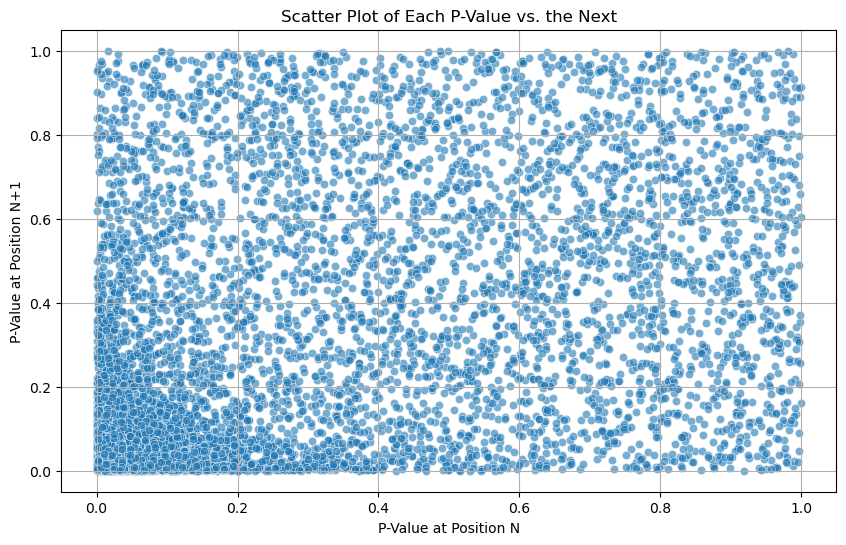

In [163]:
x_p_values = p_values[:-1]  # All except the last p-value
y_p_values = p_values[1:]   # All except the first p-value

plt.figure(figsize=(10, 6))
plt.scatter(x_p_values, y_p_values, alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Scatter Plot of Each P-Value vs. the Next')
plt.xlabel('P-Value at Position N')
plt.ylabel('P-Value at Position N+1')
plt.grid(True)
plt.show()

We see that the p_values are correlated at proximal sites when the p-values are low. For higher p-values, the correlation is not clear.

Second step is:
2. If one checks whether a p-value is below any value alpha, then this will be correlated for proximal sites. 
We show by a 2x2 table of the chance of p-value being below alpha given that the previous p-value is so or not.

We create a function to calculate the 2x2 table with the probabilities of the current p-value being below alpha given the previous p-value is below or above alpha.

In [164]:
def calculate_pvalue_table(p_values, alpha):
    count_below_below = 0
    count_below_above = 0
    count_above_below = 0
    count_above_above = 0

    # Iterate over the p-values, skipping the last one to compare pairs
    for i in range(len(p_values) - 1):
        current_below_alpha = p_values[i] < alpha
        next_below_alpha = p_values[i+1] < alpha

        if current_below_alpha:
            if next_below_alpha:
                count_below_below += 1
            else:
                count_below_above += 1
        else:
            if next_below_alpha:
                count_above_below += 1
            else:
                count_above_above += 1

    total_below = count_below_below + count_below_above
    total_above = count_above_below + count_above_above

    table = np.array([
        [count_below_below / total_below if total_below else 0, count_below_above / total_below if total_below else 0],
        [count_above_below / total_above if total_above else 0, count_above_above / total_above if total_above else 0]
    ])

    return table

In [165]:
table = calculate_pvalue_table(p_values, alpha)
print("Probability table:")
print("                  Current p-value < alpha | Current p-value >= alpha")
print(f"Previous < alpha: {table[0, 0]:.2f}                      | {table[0, 1]:.2f}")
print(f"Previous >= alpha: {table[1, 0]:.2f}                      | {table[1, 1]:.2f}")

Probability table:
                  Current p-value < alpha | Current p-value >= alpha
Previous < alpha: 0.60                      | 0.40
Previous >= alpha: 0.26                      | 0.74


We see that the chance of the current p-value being below alpha is higher if the previous p-value is below alpha.

Step 3 is:
3) Still, since there are so many sites in a given [DNA-methylation-like] dataset, these intra correlations are watered out, meaning that if one picks two p-values from the same dataset, they will be almost non-correlated (scatter plot) and the chance of being below alpha is not dependent on whether any other p-value from the same dataset is so (2x2 table being neutral)

To check the correlation between the p values at random sites, we shuffle p_values and plot the scatter plot again.

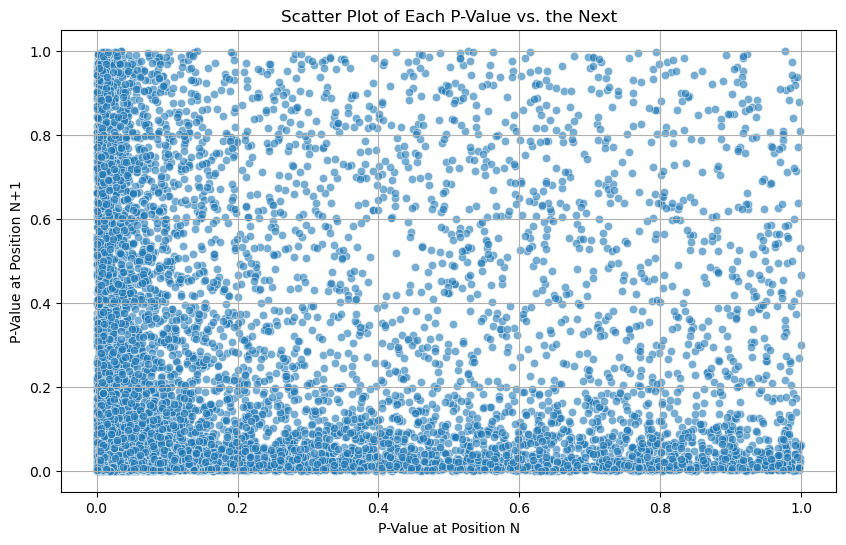

In [166]:
shuffled_p_values = np.random.permutation(p_values)

x_shuffled_p_values = shuffled_p_values[:-1]  # All except the last p-value
y_shuffled_p_values = shuffled_p_values[1:]   # All except the first p-value

plt.figure(figsize=(10, 6))
plt.scatter(x_shuffled_p_values, y_shuffled_p_values, alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Scatter Plot of Each P-Value vs. the Next')
plt.xlabel('P-Value at Position N')
plt.ylabel('P-Value at Position N+1')
plt.grid(True)
plt.show()

We see that the points are not uniformly distributed. The concentraition of points on x and y axes might be due to the fact that in this dataset there's a lot of p-values close to 0. They are however more distributed than for non-shuffled p-values.

In [167]:
table = calculate_pvalue_table(shuffled_p_values, alpha)
print("Probability table:")
print("                  Current p-value < alpha | Current p-value >= alpha")
print(f"Previous < alpha: {table[0, 0]:.2f}                      | {table[0, 1]:.2f}")
print(f"Previous >= alpha: {table[1, 0]:.2f}                      | {table[1, 1]:.2f}")

Probability table:
                  Current p-value < alpha | Current p-value >= alpha
Previous < alpha: 0.40                      | 0.60
Previous >= alpha: 0.39                      | 0.61


The table shows that the chance of the current p-value being below alpha is not dependent on whether the previous p-value is below alpha or not.

Step 4 is:
4) Since the chance of p-values being below a given alpha (success) is now essentially independent within a dataset (point 3), then the number of such successes in a dataset is close to what one would get with independent coin throws - i.e. a binomial distribution (show the empirical distribution for the number of p-values in a given dataset being below two chosen values of alpha, and plot the binomial distributions around the means of these two empirical distributions to show it is very close.

We plot the empiricial distribution of p-values:

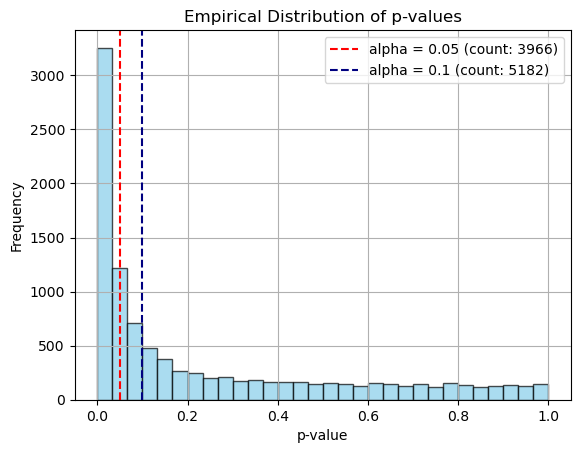

In [168]:
alpha_thresholds = [0.05, 0.10]
alpha_colors = {0.05: "red", 0.1: "navy"}
# Calculate the count of p-values below each alpha threshold.
counts_below_alpha = [np.sum(p_values < alpha) for alpha in alpha_thresholds]

# Plot the histogram of p-values.
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Mark the count of p-values below each alpha threshold on the plot.
for a, count in zip(alpha_thresholds, counts_below_alpha):
    plt.axvline(x=a, color=alpha_colors[a], linestyle='--', label=f'alpha = {a} (count: {count})')

# Annotate the count on the plot.
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Empirical Distribution of p-values')
plt.legend()
plt.grid(True)
plt.show()

We plot the empirical distribution of p-values below alpha (0.05):

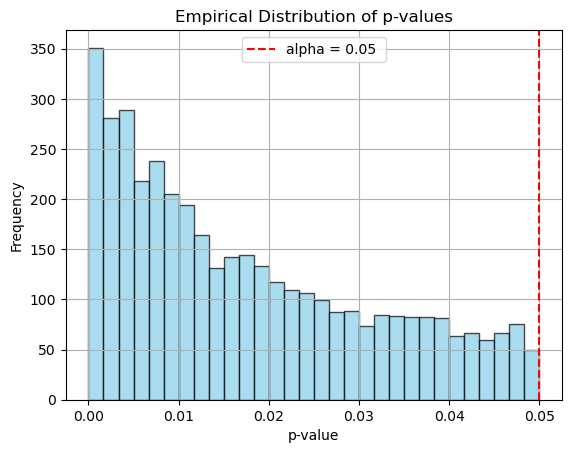

In [170]:
p_values_below_alpha = p_values[p_values < alpha]


# Plot the histogram of p-values.
plt.hist(p_values_below_alpha, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=alpha, color='red', linestyle='--', label=f'alpha = {alpha} ')


# Annotate the count on the plot.
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Empirical Distribution of p-values')
plt.legend()
plt.grid(True)
plt.show()

We see that the p-values are not uniformly distributed. There are more p-values close to 0. I however see no connection to binomial distribution and I don't know how to connect those (?)

Now I plot correlation for adjusted p_values:

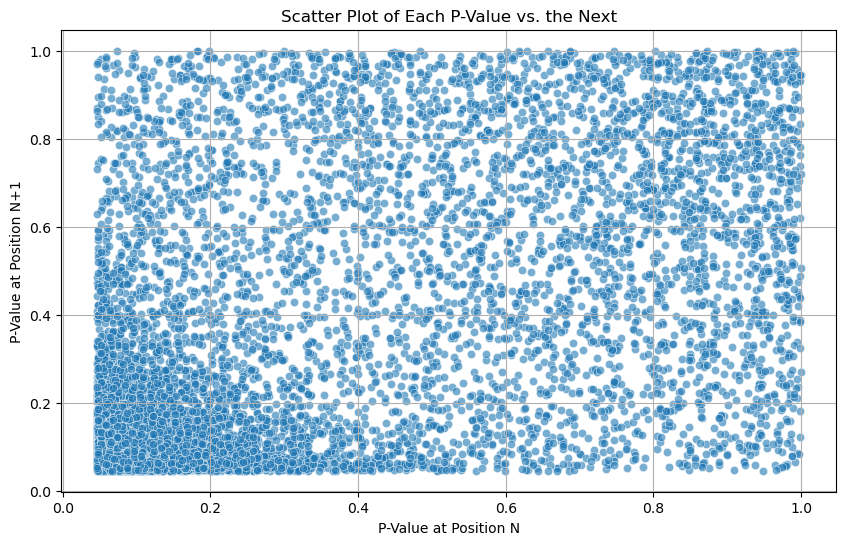

In [172]:
x_adjusted_p_values = adjusted_p_values[:-1]  # All except the last p-value
y_adjusted_p_values = adjusted_p_values[1:]   # All except the first p-value

plt.figure(figsize=(10, 6))
plt.scatter(x_adjusted_p_values, y_adjusted_p_values, alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Scatter Plot of Each P-Value vs. the Next')
plt.xlabel('P-Value at Position N')
plt.ylabel('P-Value at Position N+1')
plt.grid(True)
plt.show()

Now I plot the empirical distribution of adjusted p-values:

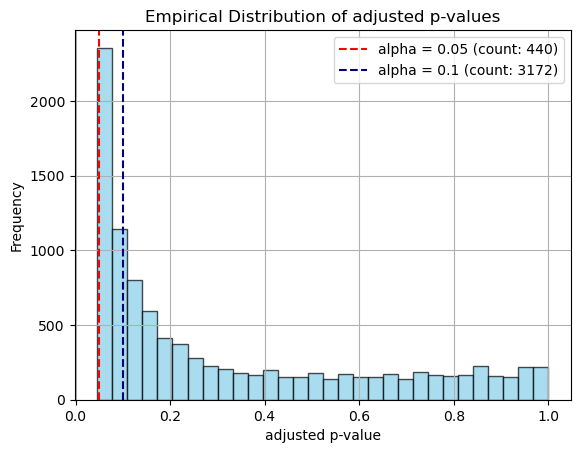

In [173]:
alpha_thresholds = [0.05, 0.10]
alpha_colors = {0.05: "red", 0.1: "navy"}
# Calculate the count of p-values below each alpha threshold.
counts_below_alpha = [np.sum(adjusted_p_values < alpha) for alpha in alpha_thresholds]

# Plot the histogram of p-values.
plt.hist(adjusted_p_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Mark the count of p-values below each alpha threshold on the plot.
for a, count in zip(alpha_thresholds, counts_below_alpha):
    plt.axvline(x=a, color=alpha_colors[a], linestyle='--', label=f'alpha = {a} (count: {count})')

# Annotate the count on the plot.
plt.xlabel('adjusted p-value')
plt.ylabel('Frequency')
plt.title('Empirical Distribution of adjusted p-values')
plt.legend()
plt.grid(True)
plt.show()

Now I plot the empirical distribution of adjusted p-values below alpha (0.05):

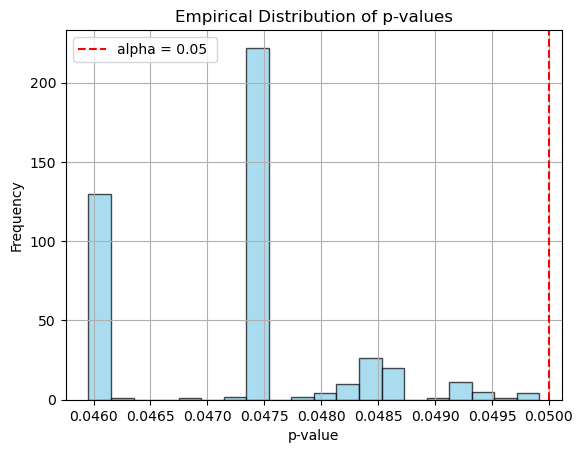

In [177]:
plt.show()
p_values_below_alpha = adjusted_p_values[adjusted_p_values < alpha]

# Plot the histogram of p-values.
plt.hist(p_values_below_alpha, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=alpha, color='red', linestyle='--', label=f'alpha = {alpha} ')

# Annotate the count on the plot.
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Empirical Distribution of p-values')
plt.legend()
plt.grid(True)
plt.show()

This looks a bit more like binomial, but I still don't see the connection. 